In [24]:
import os
import sys
import yaml
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rerf.rerfClassifier import rerfClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.utils import check_random_state

from mne_bids.path import BIDSPath
from mne import Epochs

src = "/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/"
if not src in sys.path:
    sys.path.append(src)

from mtsmorf.io.move.read import read_trial_metadata, read_move_trial_epochs
from mtsmorf.move_exp.cohort_functions import (
    read_cohort_directionality_data,
    read_cohort_movement_data,
    read_cohort_planning_data
)

from mtsmorf.io.move.read import read_move_trial_epochs, read_trial_metadata
from mtsmorf.io.utils import NumpyEncoder

sns.set_palette('Set1')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
cohort = [
    "efri07",
    "efri13",
    "efri14",
    "efri18",
    "efri20",
]

with open(Path(os.path.abspath(' ')).parents[3] / "mtsmorf/move_exp/config.yml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

with open(Path(os.path.abspath(' ')).parents[3] / "mtsmorf/move_exp/metadata.yml") as f:
    metadata = yaml.load(f, Loader=yaml.FullLoader)

root = Path(config["bids_root"])
results_path = Path(config["results_path"])
subjects = metadata["subjects"]

seed = 1
n_splits = 5
cv = GroupKFold(n_splits)
metrics = dict(accuracy="accuracy", 
            cohen_kappa_score=make_scorer(cohen_kappa_score),
            roc_auc_ovr="roc_auc_ovr")

resample_rate = 500

# Hard-coded channel selection

In [3]:
channels = {
    "efri07" : [
        "F1", "E3",       # Fusiform gyrus
        "E5", "E6",       # ITG
        "B7", "B8",       # MTG
        "U4", "U5"        # STG
    ],
    "efri13" : [
        "F'1", "E'4",
        "E'8", "E'7",
        "F'7", "F'9",
        "U'3", "U'4",
    ],
    "efri14" : [
        "F'1", "F'2",
        "F'3", "F'6",
        "B'7", "B'8",
        "U'8", "U'7"
    ],
    "efri18" : [
        "F'1", "F'2",
        "B'6", "B'7",
        "TP'9", "F'14",
        "U'8", "U'6"
    ],
    "efri20" : [
        "E4", "O1",
        "O8", "O9",
        "C12", "C14",
        "C10", "C9"
    ],
}

## Decode Directionality

l or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to un

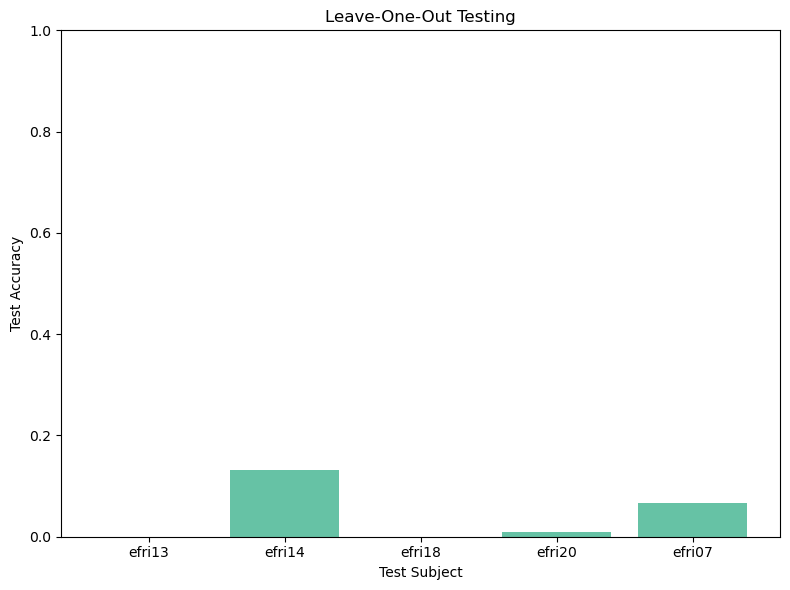

<Figure size 432x288 with 0 Axes>

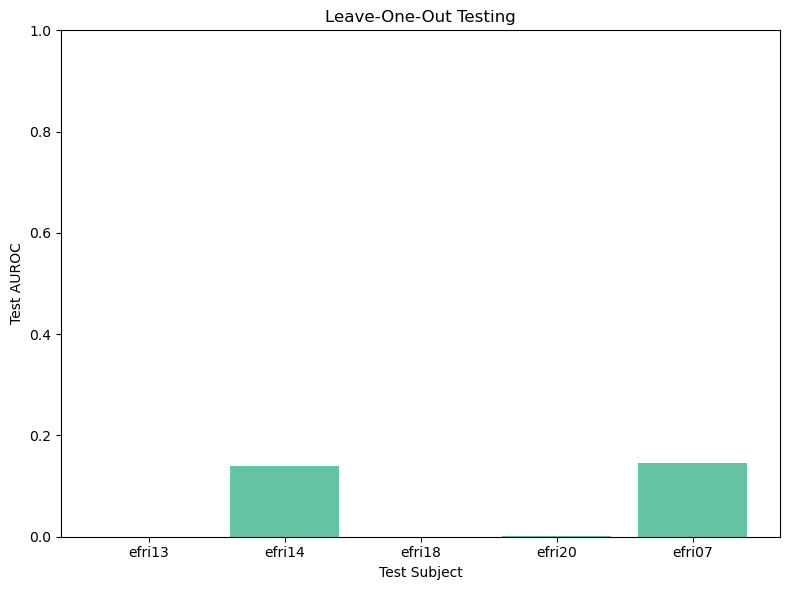

<Figure size 432x288 with 0 Axes>

In [4]:
destination_path = results_path / "cohort_decode_directionality"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_directionality_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)

dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_accuracy"]) - np.array(dummy_scores["test_accuracy"]))
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF_diff.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_roc_auc_ovr"]) - np.array(dummy_scores["test_roc_auc_ovr"]))
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF_diff.png")

## Decode Movement

 Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/r

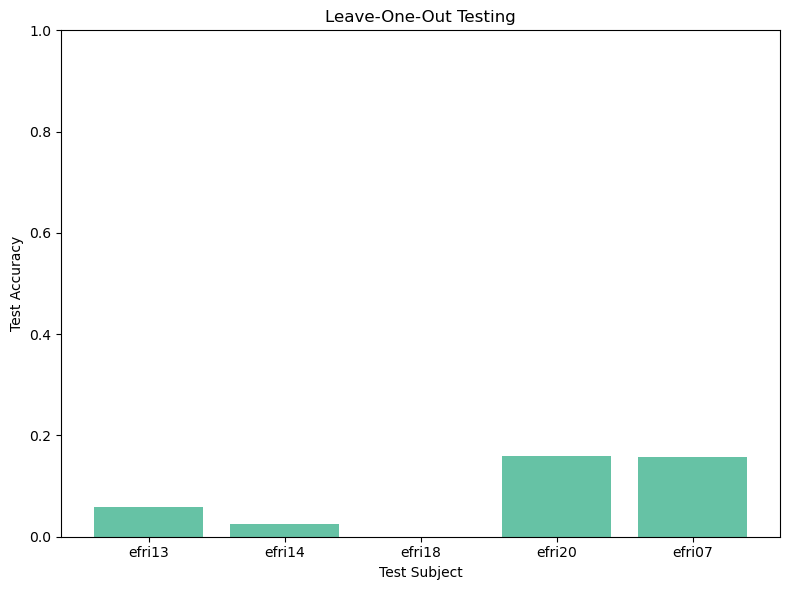

<Figure size 432x288 with 0 Axes>

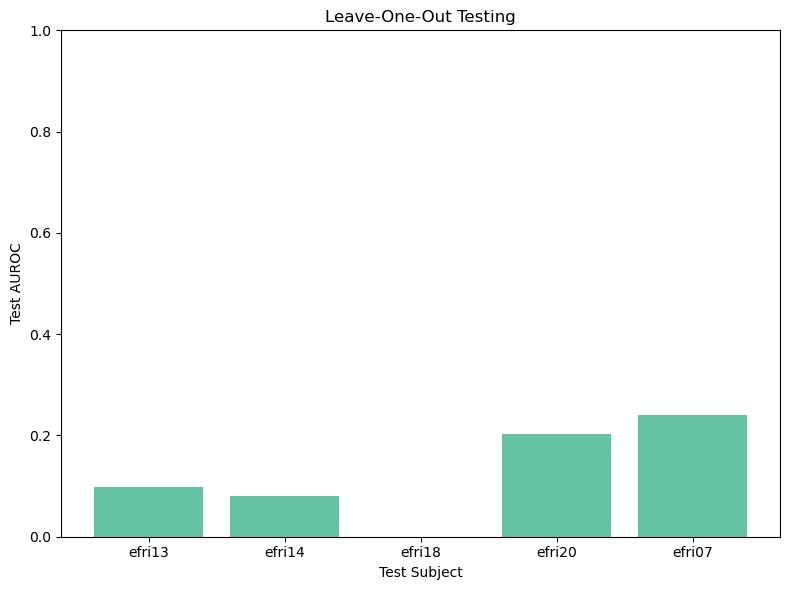

<Figure size 432x288 with 0 Axes>

In [5]:
destination_path = results_path / "cohort_decode_movement"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_movement_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)

dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_accuracy"]) - np.array(dummy_scores["test_accuracy"]))
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF_diff.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_roc_auc_ovr"]) - np.array(dummy_scores["test_roc_auc_ovr"]))
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF_diff.png")

## Planning Movement

erturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsucces

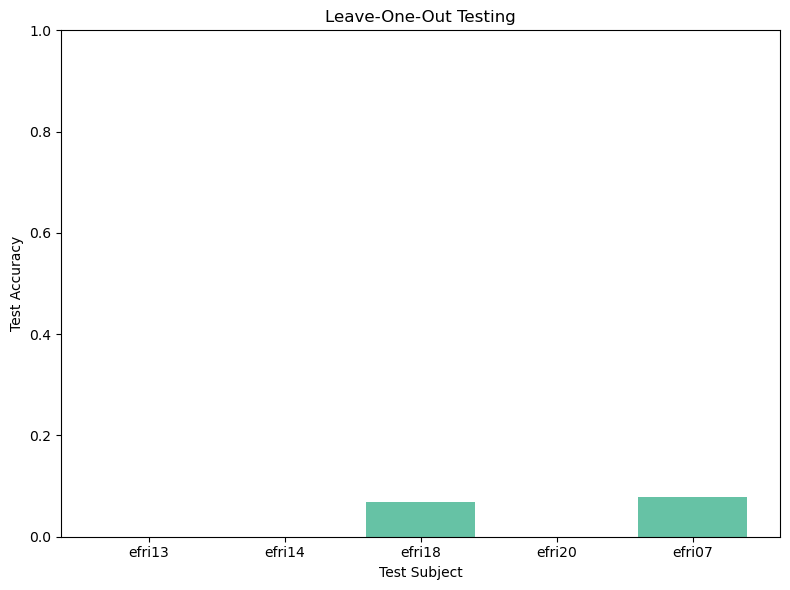

<Figure size 432x288 with 0 Axes>

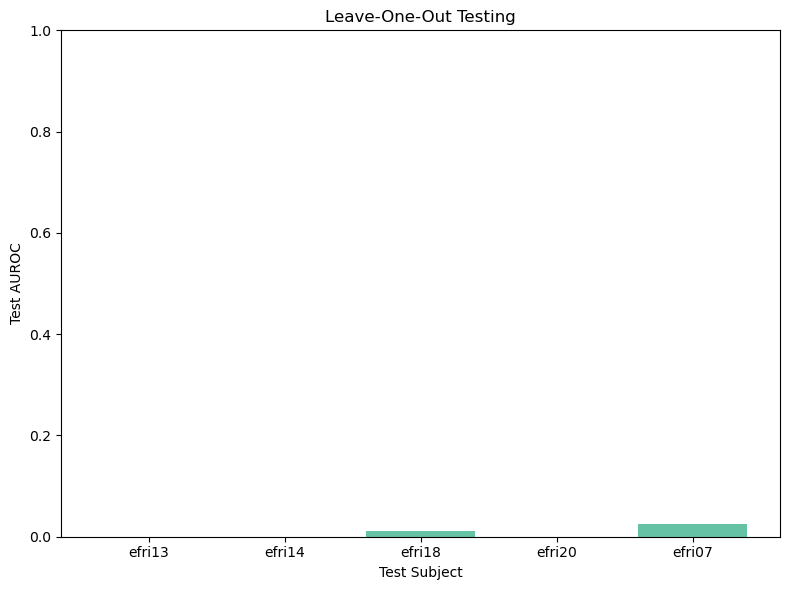

<Figure size 432x288 with 0 Axes>

In [6]:
destination_path = results_path / "cohort_planning_movement"
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

data, labels, groups = read_cohort_planning_data(root, cohort, channels, resample_rate=resample_rate)

random_state = 1
image_height, image_width = data.shape[1:]
clf = rerfClassifier(
    n_estimators=500,
    projection_matrix="MT-MORF",
    max_features="auto",
    n_jobs=-1,
    random_state=random_state,
    image_height=image_height,
    image_width=image_width,
)

X = data.reshape(data.shape[0], -1)
y = labels

# TODO: plot diff in accuracies and auroc

# Plot for MT-MORF
scores = cross_validate(clf, X, y, groups=groups, scoring=metrics, cv=cv, 
                        return_train_score=True, return_estimator=True)

dummy = DummyClassifier(strategy="most_frequent", random_state=random_state)
dummy_scores = cross_validate(dummy, X, y, groups=groups, scoring=metrics, cv=cv, 
                            return_train_score=True, return_estimator=True)

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_accuracy"]) - np.array(dummy_scores["test_accuracy"]))
ax.set(xlabel="Test Subject", ylabel="Test Accuracy", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_accuracy_baseline_MT-MORF_diff.png")

fig, ax = plt.subplots(dpi=100, figsize=(8, 6))
ax.bar(["efri13", "efri14", "efri18", "efri20", "efri07"], np.array(scores["test_roc_auc_ovr"]) - np.array(dummy_scores["test_roc_auc_ovr"]))
ax.set(xlabel="Test Subject", ylabel="Test AUROC", ylim=[0, 1], title="Leave-One-Out Testing")
fig.tight_layout()
plt.show()
plt.savefig(destination_path / "leave_one_out_auroc_baseline_MT-MORF_diff.png")

# Automated Channel Selection

In [26]:
import json
subjects = metadata["subjects"]

frequency_bands = dict(
    delta=(0.5, 4),
    theta=(4, 8),
    alpha=(8, 13),
    beta=(13, 30),
    gamma=(30, 70),
    hi_gamma=(70, 200),
)
subjects = metadata["subjects"]
subject_scores_bands = {}
for subject in subjects:
    subject_scores_bands[subject] = {}
    for band in frequency_bands:
        with open(
            results_path 
            / f"decode_directionality/{subject}/hilbert_transform/tmin=0_tmax=0.25/{subject}_MT-MORF_{band}.json", "r"
        ) as f:
            subject_scores_bands[subject][band] = json.load(f)

In [45]:
auroc_df = []
for subject in subject_scores_bands:
    for band in subject_scores_bands[subject]:
        aurocs = subject_scores_bands[subject][band]["test_roc_auc_ovr"]
        accs = subject_scores_bands[subject][band]["test_accuracy"]
        for auroc, acc in zip(aurocs, accs):
            auroc_df.append((subject, band, auroc, acc))
auroc_df = pd.DataFrame(auroc_df, columns=["subject", "band", "auroc", "accuracy"])
auroc_df

,subject,band,auroc,accuracy
0,efri02,delta,0.638766,0.428571
1,efri02,delta,0.760887,0.428571
2,efri02,delta,0.554514,0.333333
3,efri02,delta,0.646181,0.285714
4,efri02,delta,0.594271,0.333333
...,...,...,...,...
295,efri26,hi_gamma,0.530655,0.210526
296,efri26,hi_gamma,0.679167,0.473684
297,efri26,hi_gamma,0.550298,0.263158
298,efri26,hi_gamma,0.541484,0.315789


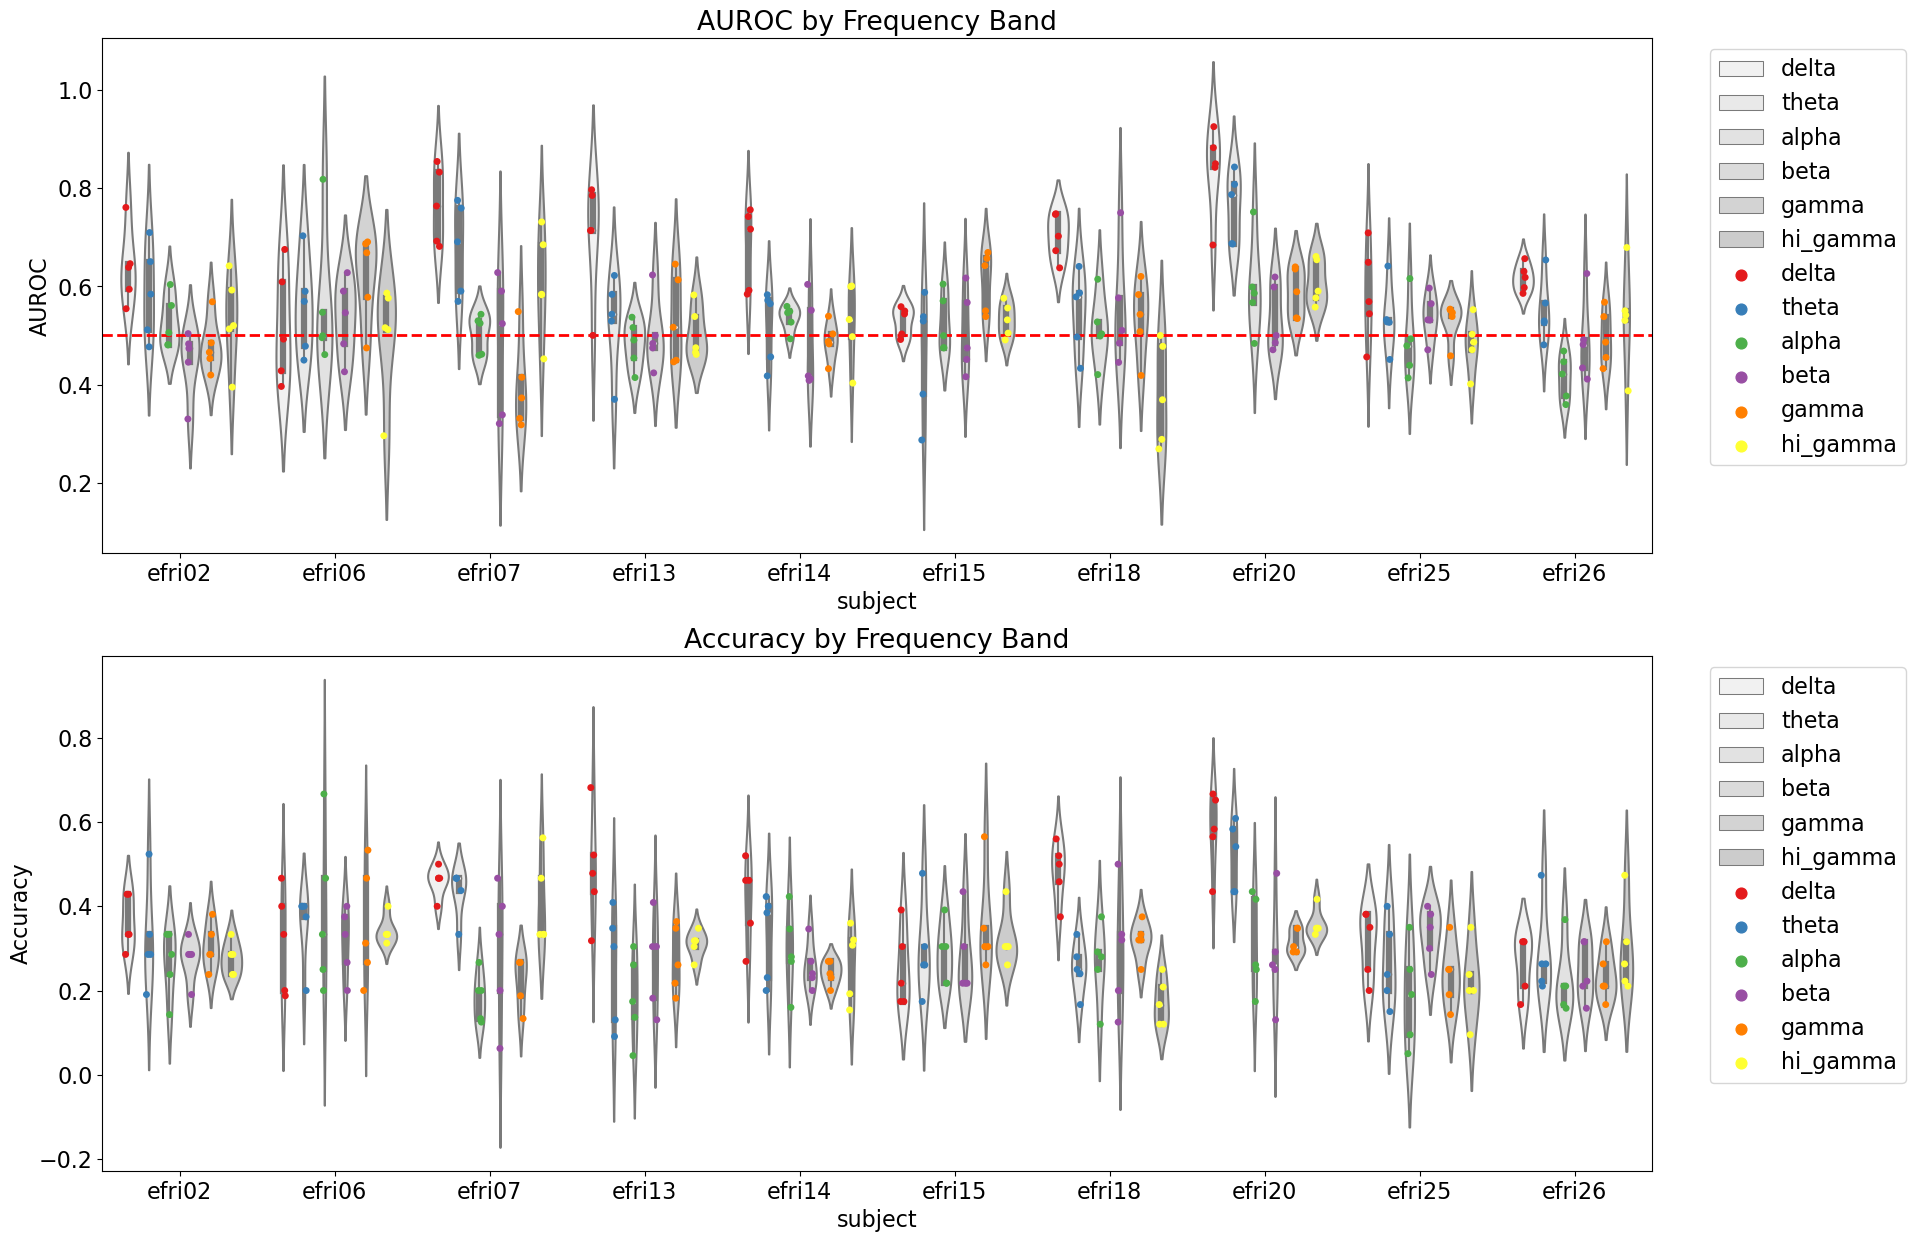

In [49]:
plt.rcParams.update({
    "font.size" : 16,
})

fig, axs = plt.subplots(2, 1, figsize=(20, 15), dpi=100, facecolor='w')
metrics = ["AUROC", "Accuracy"]
for ax, metric in zip(axs, metrics):
    ax = sns.violinplot(x="subject", y=metric.lower(), hue="band", dodge=True, data=auroc_df, color="0.8", legend=False, ax=ax)
    ax = sns.stripplot(x="subject", y=metric.lower(), hue="band", dodge=True, data=auroc_df, ax=ax)
    ax.legend(bbox_to_anchor=(1.03, 1))
    ax.set_title(f'{metric} by Frequency Band')
    ax.set_ylabel(f'{metric}')
    if metric == "AUROC":
        ax.axhline(0.5, ls="--", lw=2, c='r');

In [50]:
top_channels_by_band = {}
subject = "efri07"
for band in frequency_bands:
    epochs = read_move_trial_epochs(root, subject, resample_rate=None)
    band_imps = subject_scores_bands[subject][band]
    result = {
        "importances_mean": np.array(band_imps["validate_roc_auc_ovr_imp_mean"]),
        "importances": np.array(band_imps["validate_roc_auc_ovr_importances"]),
        "patch_inds": np.array(band_imps["validate_roc_auc_ovr_patch_inds"]),
        "usage_counts": np.array(band_imps["validate_roc_auc_ovr_usage_counts"])
    }

    imp_mean = np.array(result["importances_mean"])
    imp_mean[imp_mean <= 0] = 0.0
    imp_double_mean = np.mean(imp_mean, axis=1)
    order = np.argsort(imp_double_mean)
    top_channels_by_band[band] = (np.array(epochs.ch_names)[order[-10:]], imp_double_mean[order[-10:]])

perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsucce

In [51]:
top_channels_bands_df = []
for band, (ch_names, imps) in top_channels_by_band.items():
    new_names = [f"{ch}-{band}" for ch in ch_names]
    top_channels_bands_df.extend(list(zip(new_names, imps, ch_names)))
top_channels_bands_df = pd.DataFrame(top_channels_bands_df, columns=["Channel Name", "Average Positive Patch Importance", "name"])
sorted_top_channels = top_channels_bands_df.sort_values("Average Positive Patch Importance", ascending=True)
sorted_top_channels.tail(10)

,Channel Name,Average Positive Patch Importance,name
45,X1-gamma,0.040741,X1
27,F1-alpha,0.040797,F1
46,P7-gamma,0.041766,P7
47,V7-gamma,0.042063,V7
28,P3-alpha,0.043212,P3
48,D1-gamma,0.047121,D1
49,P6-gamma,0.050816,P6
29,G1-alpha,0.061939,G1
19,B7-theta,0.070932,B7
9,B7-delta,0.075018,B7


In [63]:
from mtsmorf.io.read import _get_anatomical_bad_chs
from mne_bids.tsv_handler import _from_tsv

channels = []
path_identifiers = dict(
    subject=subjects[0],
    session="efri",
    task="move",
    acquisition="seeg",
    run="01",
    suffix="ieeg",
    extension=".vhdr",
    root=root
)
for subject in subjects:
    path_identifiers["subject"] = subject
    path_identifiers["extension"] = ".tsv"
    bids_path = BIDSPath(**path_identifiers)
    bids_path.update(suffix="channels")
    bads = _get_anatomical_bad_chs(bids_path)
    
    tmp = _from_tsv(bids_path)
    tmp = [
        (name, anat, subject) 
        for (name, anat) in zip(tmp["name"], tmp["anat"]) 
        if name not in bads
    ]

    channels.extend(tmp)

channels = pd.DataFrame(channels, columns=["name", "anat", "subject"])
channels.head()
sorted_channels = channels.sort_values(["anat", "subject"])

In [57]:
sorted_top_channels_w_anat = sorted_top_channels.merge(sorted_channels[sorted_channels.subject == "efri07"], how="left", on="name")
print(*{anat: list(group.name.values) for anat, group in sorted_top_channels_w_anat[-10:].groupby("anat")}.items(), sep="\n")

('angular gyrus R', ['P7'])
('cingulate cortex (posterior) R', ['X1', 'D1'])
('fusiform gyrus R', ['F1'])
('intraparietal sulcus R', ['P6'])
('lingula gyrus R', ['G1'])
('middle temporal gyrus R', ['B7', 'B7'])
('occipital gyrus R', ['V7'])
('parietooccipital sulcus R', ['P3'])


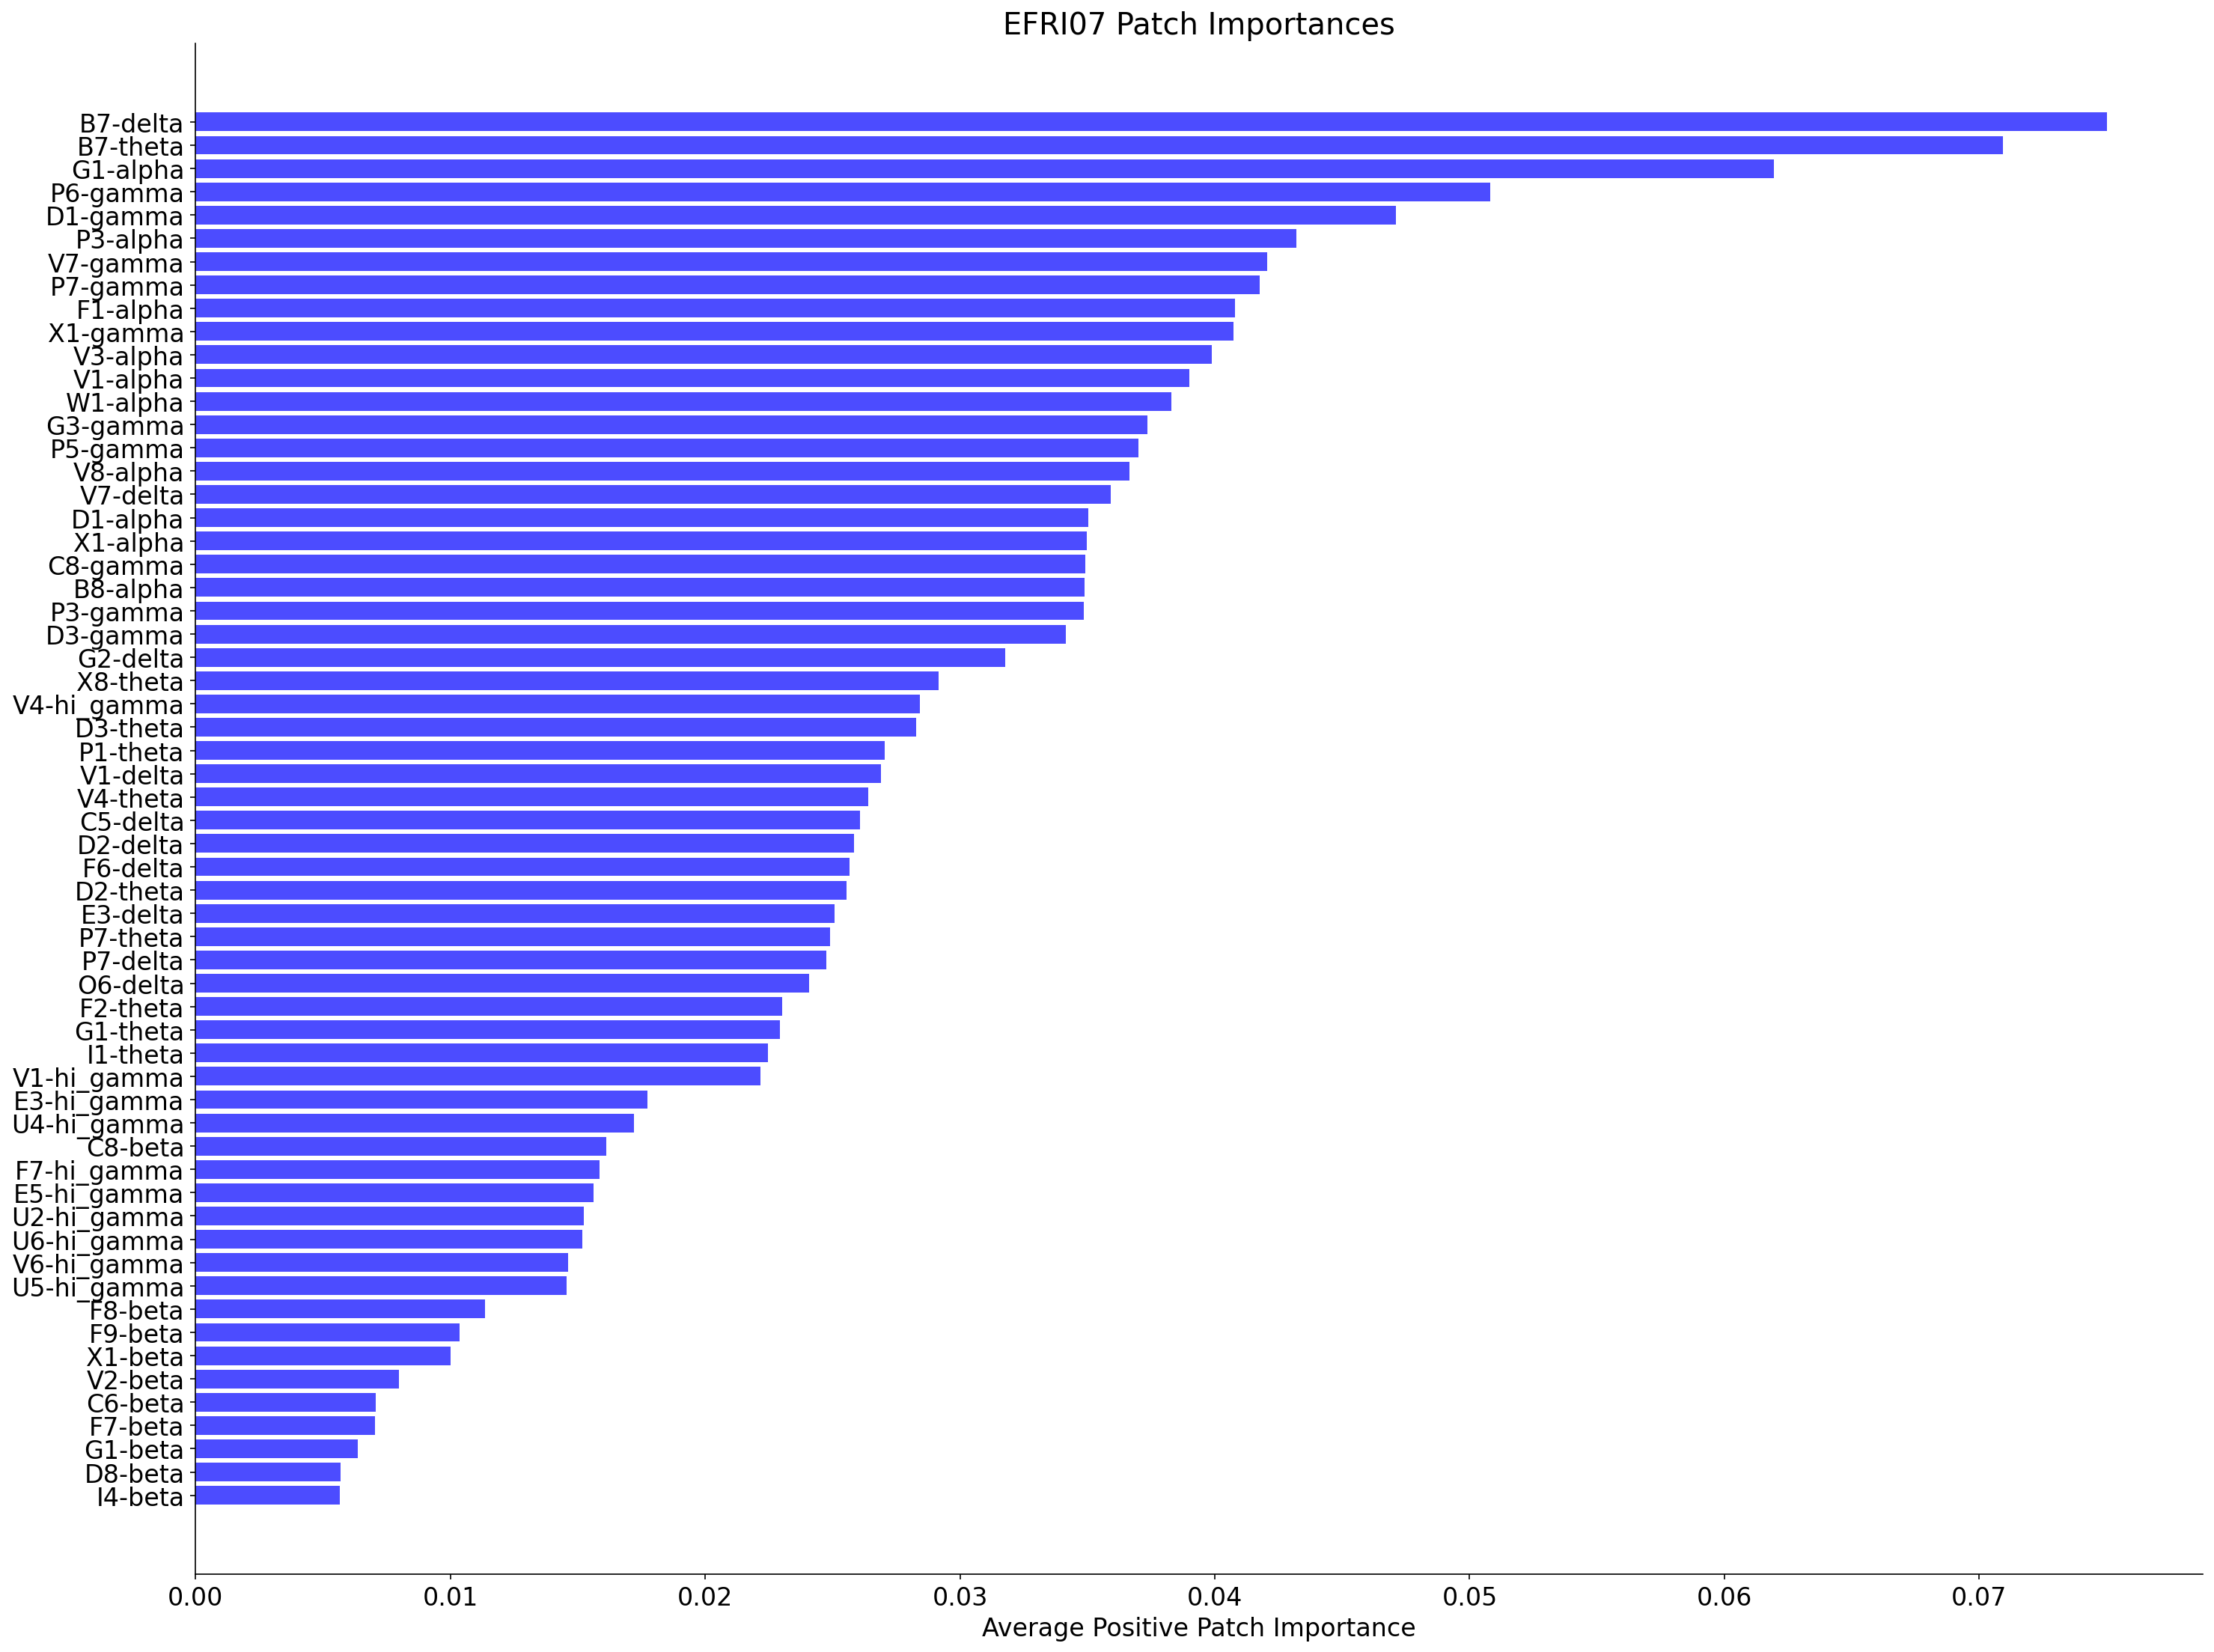

In [62]:
fig, ax = plt.subplots(dpi=150, figsize=(20, 15))
ax.barh(sorted_top_channels_w_anat["Channel Name"], sorted_top_channels_w_anat["Average Positive Patch Importance"], color="blue", alpha=0.7)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xlabel("Average Positive Patch Importance")
ax.set_title("EFRI07 Patch Importances")
fig.tight_layout();

In [65]:
top_performers_time_domain = ["efri07", "efri13", "efri14", "efri18", "efri20"]
top_channels_df = {}
for subject in top_performers_time_domain:
    epochs = read_move_trial_epochs(root, subject, resample_rate=None)
    top_channels_df[subject] = []
    for band in frequency_bands:
        band_imps = subject_scores_bands[subject][band]
        result = {
            "importances_mean": np.array(band_imps["validate_roc_auc_ovr_imp_mean"]),
            "importances": np.array(band_imps["validate_roc_auc_ovr_importances"]),
            "patch_inds": np.array(band_imps["validate_roc_auc_ovr_patch_inds"]),
            "usage_counts": np.array(band_imps["validate_roc_auc_ovr_usage_counts"])
        }

        imp_mean = np.array(result["importances_mean"])
        imp_mean[imp_mean <= 0] = 0.0
        imp_double_mean = np.mean(imp_mean, axis=1)
        order = np.argsort(imp_double_mean)
        top_chs = np.array(epochs.ch_names)[order[-10:]]
        top_imps = imp_double_mean[order[-10:]]
        top_channels_df[subject].extend(list(zip(top_chs, top_imps, np.repeat(subject, len(top_chs)), np.repeat(band, len(top_chs)))))

bed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding/mtsmorf/io/move/read.py:99: RuntimeWarning: Cant add xy metrics to unsuccessful or perturbed trial.
  warn(f'Cant add xy metrics to unsuccessful or perturbed trial.')
/Users/ChesterHuynh/OneDrive - Johns Hopkin

In [66]:
top_channels_all_subjects = pd.concat([pd.DataFrame(df) for df in top_channels_df.values()])
top_channels_all_subjects.columns = ["name", "Average Positive Patch Importance", "subject", "band"]
top_channels_all_subjects = top_channels_all_subjects.merge(sorted_channels, how="left", on=["subject", "name"])
top_channels_all_subjects.head()

,name,Average Positive Patch Importance,subject,band,anat
0,O6,0.024068,efri07,delta,orbitofrontal cortex (lateral) R
1,P7,0.024749,efri07,delta,angular gyrus R
2,E3,0.025079,efri07,delta,fusiform gyrus R
3,F6,0.025665,efri07,delta,inferior temporal sulcus R
4,D2,0.025844,efri07,delta,cingulate cortex (posterior) R


In [67]:
shared_anat = top_channels_all_subjects.groupby("anat")["subject"].nunique()[top_channels_all_subjects.groupby("anat")["subject"].nunique() > 1].index
top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)]

,name,Average Positive Patch Importance,subject,band,anat
1,P7,0.024749,efri07,delta,angular gyrus R
2,E3,0.025079,efri07,delta,fusiform gyrus R
3,F6,0.025665,efri07,delta,inferior temporal sulcus R
4,D2,0.025844,efri07,delta,cingulate cortex (posterior) R
9,B7,0.075018,efri07,delta,middle temporal gyrus R
...,...,...,...,...,...
292,X13,0.020015,efri20,hi_gamma,middle temporal gyrus R
293,O9,0.020175,efri20,hi_gamma,inferior temporal gyrus R
295,F12,0.022790,efri20,hi_gamma,inferior temporal gyrus R
296,O5,0.022816,efri20,hi_gamma,inferior temporal sulcus R


In [68]:
for anat, group in top_channels_all_subjects[top_channels_all_subjects.anat.isin(shared_anat)].groupby("anat"):
    print(*zip(list(group["subject"]), np.repeat(anat, len(group)), [f"{s}: {ch} ({b})" for s, ch, b in zip(group["subject"].str.upper().values, group["name"].values, group["band"].values)]), sep="\n")
    # print(group[["subject", "band", "name"]])

('efri13', 'angular gyrus L', "EFRI13: P'7 (beta)")
('efri14', 'angular gyrus L', "EFRI14: Y'9 (gamma)")
('efri18', 'angular gyrus L', "EFRI18: P'10 (alpha)")
('efri18', 'angular gyrus L', "EFRI18: P'9 (gamma)")
('efri07', 'angular gyrus R', 'EFRI07: P7 (delta)')
('efri07', 'angular gyrus R', 'EFRI07: P7 (theta)')
('efri07', 'angular gyrus R', 'EFRI07: D8 (beta)')
('efri07', 'angular gyrus R', 'EFRI07: P7 (gamma)')
('efri13', 'angular gyrus R', 'EFRI13: P8 (gamma)')
('efri20', 'angular gyrus R', 'EFRI20: P12 (alpha)')
('efri20', 'angular gyrus R', 'EFRI20: P13 (alpha)')
('efri20', 'angular gyrus R', 'EFRI20: P11 (alpha)')
('efri20', 'angular gyrus R', 'EFRI20: P13 (beta)')
('efri20', 'angular gyrus R', 'EFRI20: P13 (gamma)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: D2 (delta)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: D2 (theta)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: X1 (alpha)')
('efri07', 'cingulate cortex (posterior) R', 'EFRI07: D1 (alpha)